In [93]:
%pip install --upgrade tensorflow keras scikit-learn opencv-python matplotlib keras_tuner keras_cv numpy seaborn

  Using cached numpy-2.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [94]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow INFO and WARNING messages

In [95]:
import tensorflow as tf
import keras

print(tf.__version__)
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

2.17.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [96]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [97]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

In [98]:
import tensorflow as tf
import keras
import pandas as pd
import os
import keras_cv
import matplotlib.pyplot as plt

In [99]:
csv_file = 'ham10000_data/HAM10000_metadata.csv'
img_dir = 'ham10000_data/images'
file_ext = '.jpg'

df = pd.read_csv(csv_file)

image_paths = [
    os.path.join(img_dir, image_id + file_ext)
    for image_id in df['image_id']
]

print(f"Number of images: {len(image_paths)}")
print(f"First 5 image paths: {image_paths[:5]}")

classes = sorted(df['dx'].unique())
num_classes = len(classes)

print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")

labels = df['dx'].map(lambda x: classes.index(x)).values
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

print(f"Class to Index Mapping: {class_to_idx}")
print(f"Labels: {labels}")

Number of images: 10015
First 5 image paths: ['ham10000_data/images/ISIC_0027419.jpg', 'ham10000_data/images/ISIC_0025030.jpg', 'ham10000_data/images/ISIC_0026769.jpg', 'ham10000_data/images/ISIC_0025661.jpg', 'ham10000_data/images/ISIC_0031633.jpg']
Number of classes: 7
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Class to Index Mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Labels: [2 2 2 ... 0 0 4]


In [100]:
from IPython.display import display

display(df.head())

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [101]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

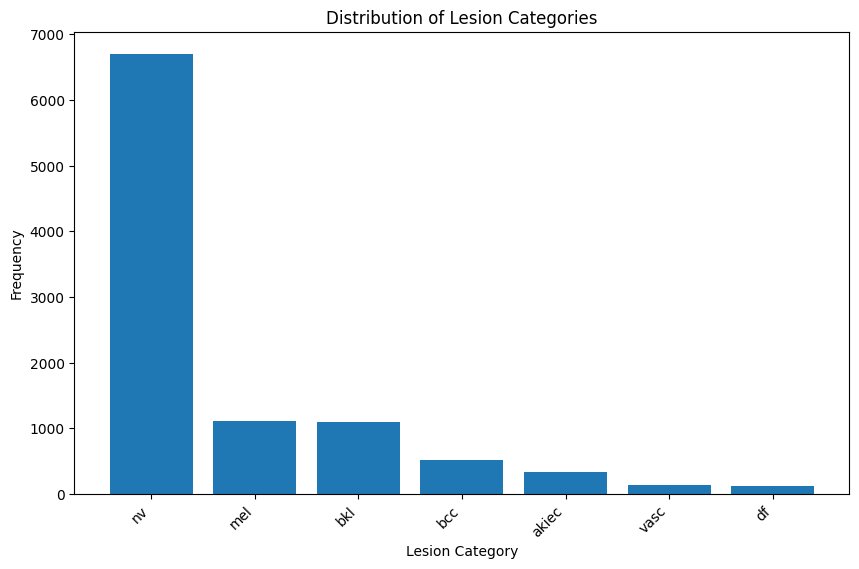

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
value_counts = df['dx'].value_counts()

plt.bar(value_counts.index, value_counts.values)
plt.title('Distribution of Lesion Categories')
plt.xlabel('Lesion Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

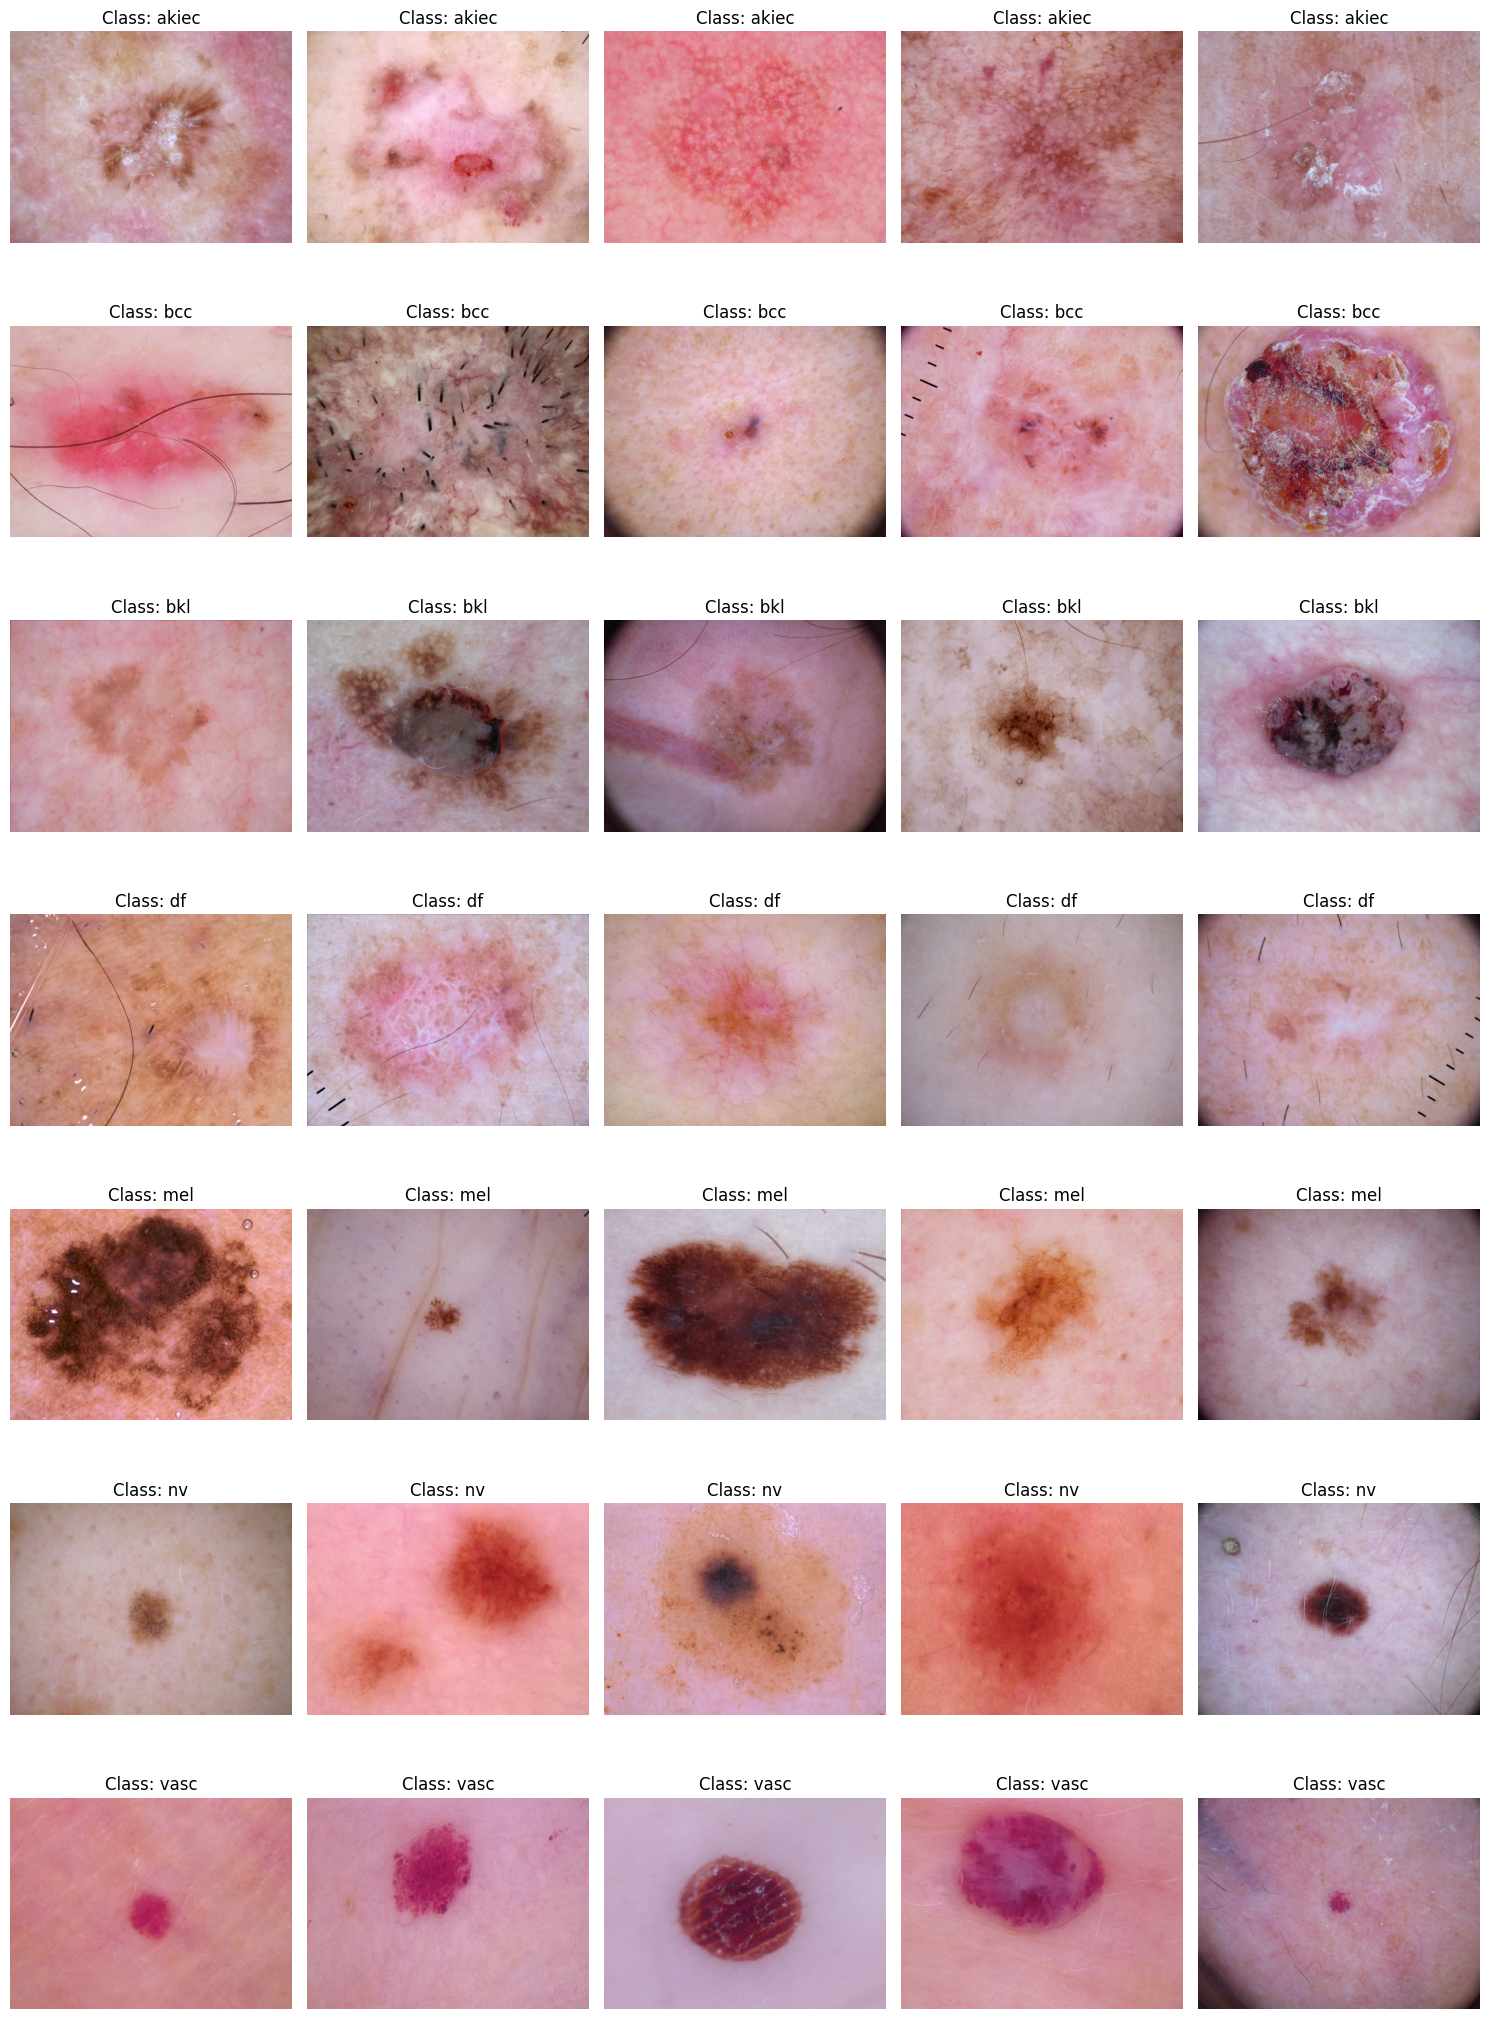

In [103]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf

n_samples_per_class = 5

plt.figure(figsize=(15, len(classes) * 3))

for class_index, class_name in enumerate(classes):
    class_indices = [i for i, label in enumerate(labels) if label == class_index]

    random_class_indices = random.sample(class_indices, min(n_samples_per_class, len(class_indices)))

    for i, idx in enumerate(random_class_indices):
        img_path = image_paths[idx]
        label = labels[idx]

        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)

        # Display image
        plt.subplot(len(classes), n_samples_per_class, class_index * n_samples_per_class + i + 1)
        plt.imshow(img)
        plt.title(f"Class: {class_name}")
        plt.axis('off')

plt.tight_layout()
plt.show()


In [104]:
def load_and_preprocess_image(image_id, label):
    # Load and preprocess the image
    image = tf.io.read_file(image_id)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))  # ResNet expects 224x224 images
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing for ResNet

    return image, label


In [105]:
from sklearn.model_selection import StratifiedShuffleSplit

train_paths = []
train_labels = []
val_paths = []
val_labels = []

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in sss.split(image_paths, labels):
    train_paths = [image_paths[i] for i in train_index]
    train_labels = labels[train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = labels[val_index]

print(f"Training set size: {len(train_paths)}")
print(f"Validation set size: {len(val_paths)}")

train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

Training set size: 8012
Validation set size: 2003


In [106]:
batch_size = 32

train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()

val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache()


In [107]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
    keras.layers.RandomTranslation(0.1, 0.1),
])

In [108]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Compute class counts and class priors
class_counts = np.bincount(train_labels)
total_counts = np.sum(class_counts)
class_prior = class_counts / total_counts

# Clip class_prior to avoid log(0)
class_prior = np.clip(class_prior, 1e-7, 1.0)
output_bias = np.log(class_prior)

print(f"Class Counts: {class_counts}")
print(f"Class Prior: {class_prior}")
print(f"Output Bias: {output_bias}")

Class Counts: [ 262  411  879   92  890 5364  114]
Class Prior: [0.03270095 0.05129805 0.10971043 0.01148278 0.11108337 0.66949576
 0.01422866]
Output Bias: [-3.42035119 -2.97010248 -2.2099108  -4.46690712 -2.19747423 -0.40123045
 -4.25249725]


In [109]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Conv2D, Multiply, Add, Concatenate, Activation

class CBAM(Layer):
    def __init__(self, reduction_ratio=8):
        super(CBAM, self).__init__()
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.channel_axis = -1
        self.channel = input_shape[self.channel_axis]

        self.shared_dense_one = Dense(self.channel // self.reduction_ratio,
                                      activation='relu',
                                      kernel_initializer='he_normal',
                                      use_bias=False)
        self.shared_dense_two = Dense(self.channel,
                                      activation='sigmoid',
                                      kernel_initializer='he_normal',
                                      use_bias=False)
        self.conv = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def channel_attention(self, input_tensor):
        avg_pool = GlobalAveragePooling2D()(input_tensor)
        avg_pool = Reshape((1, 1, self.channel))(avg_pool)

        max_pool = GlobalMaxPooling2D()(input_tensor)
        max_pool = Reshape((1, 1, self.channel))(max_pool)

        avg_out = self.shared_dense_one(avg_pool)
        avg_out = self.shared_dense_two(avg_out)

        max_out = self.shared_dense_one(max_pool)
        max_out = self.shared_dense_two(max_out)

        combined = Add()([avg_out, max_out])
        scale = Activation('sigmoid')(combined)

        return Multiply()([input_tensor, scale])

    def spatial_attention(self, input_tensor):
        avg_pool = tf.reduce_mean(input_tensor, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(input_tensor, axis=-1, keepdims=True)
        concat = Concatenate(axis=-1)([avg_pool, max_pool])
        spatial_attention = self.conv(concat)
        return Multiply()([input_tensor, spatial_attention])

    def call(self, input_tensor):
        x = self.channel_attention(input_tensor)
        x = self.spatial_attention(x)
        return x


In [110]:
from tensorflow import keras
import numpy as np

def build_resnet50_model_with_cbam(num_classes, class_prior):

    # Load the base ResNet50 model with ImageNet weights, excluding the top layer
    base_model = keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling=None
    )

    # Freeze the base model to prevent its weights from being updated
    base_model.trainable = False

    # Input layer
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)

    # Add CBAM block after the backbone
    x = CBAM()(x)  # Integrating the CBAM block here

    # Global Average Pooling and output layers
    x = keras.layers.GlobalAveragePooling2D()(x)

    # Bias initialization for class imbalance
    output_bias = np.log(class_prior)

    # Output layer with softmax activation for multi-class classification
    outputs = keras.layers.Dense(
        num_classes,
        activation='softmax',
        bias_initializer=keras.initializers.Constant(output_bias),
    )(x)

    # Create the model
    model = keras.Model(inputs, outputs)

    # Compile the model with AdamW optimizer and sparse categorical crossentropy
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_resnet50_model_with_cbam(num_classes, class_prior)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam (CBAM)                     │ (None, 7, 7, 2048)     │     1,048,675 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 7)              │        14,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,650,730 (94.04 MB)

 Trainable params: 1,063,018 (4.06 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [111]:
from keras.callbacks import ModelCheckpoint

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=1e-4,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        min_lr=1e-7
    ),
    ModelCheckpoint(
        filepath='models/resnet50-tuned.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    callbacks=callbacks
)

Epoch 1/500


I0000 00:00:1728308263.206244   18044 service.cc:146] XLA service 0x7f8ac8003120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728308263.206291   18044 service.cc:154]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728308263.206295   18044 service.cc:154]   StreamExecutor device (1): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/251 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7413 - loss: 0.8685 

I0000 00:00:1728308269.960550   18044 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7027 - loss: 0.8727
Epoch 1: val_loss improved from inf to 0.67720, saving model to models/resnet50-tuned.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 46s 123ms/step - accuracy: 0.7028 - loss: 0.8722 - val_accuracy: 0.7444 - val_loss: 0.6772 - learning_rate: 0.0010
Epoch 2/500
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7774 - loss: 0.6050
Epoch 2: val_loss improved from 0.67720 to 0.63297, saving model to models/resnet50-tuned.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.7774 - loss: 0.6049 - val_accuracy: 0.7629 - val_loss: 0.6330 - learning_rate: 0.0010
Epoch 3/500
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8033 - loss: 0.5385
Epoch 3: val_loss improved from 0.63297 to 0.61933, saving model to models/resnet50-tuned.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.8033 - loss: 0.5385 - val_accuracy: 0.7678 - val_loss: 0.6193 - learning_rate: 0.0010
Epoch 4/500
251/251 ━━━━━━━━━━━━━━

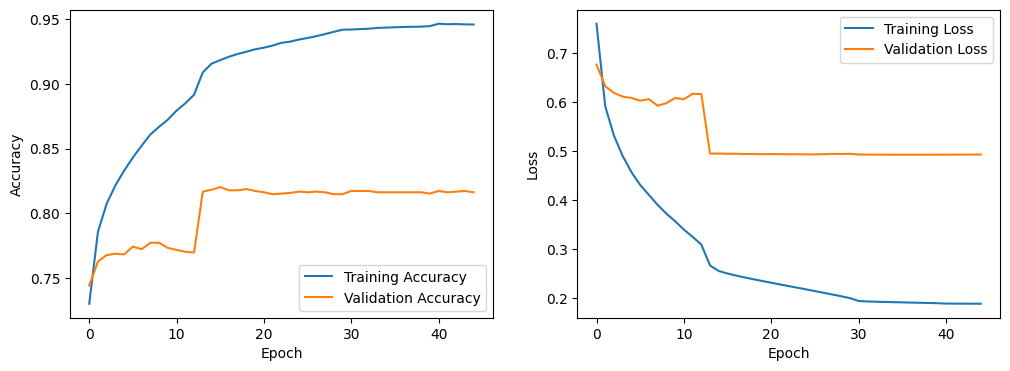

In [112]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

y_true = []
y_pred = []

def get_predictions(dataset):
    for images, labels in dataset:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
    return np.array(y_true), np.array(y_pred)

# Get predictions for validation dataset
y_true, y_pred = get_predictions(val_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━

In [114]:
# Classification Report

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

       akiec       0.67      0.55      0.61        65
         bcc       0.63      0.64      0.63       103
         bkl       0.67      0.66      0.67       220
          df       0.71      0.43      0.54        23
         mel       0.58      0.50      0.54       223
          nv       0.89      0.93      0.91      1341
        vasc       0.78      0.64      0.71        28

    accuracy                           0.82      2003
   macro avg       0.71      0.62      0.66      2003
weighted avg       0.81      0.82      0.81      2003



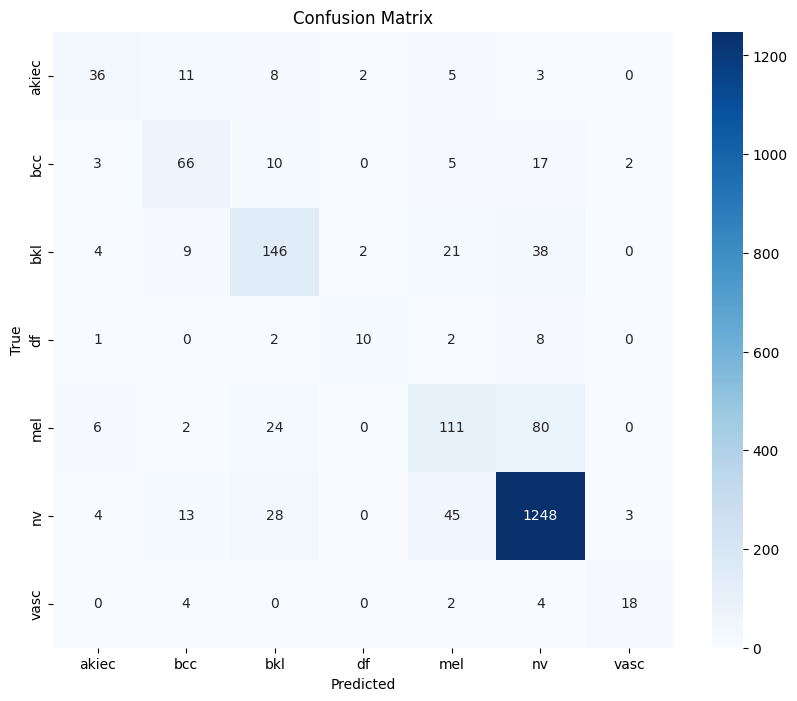

In [115]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

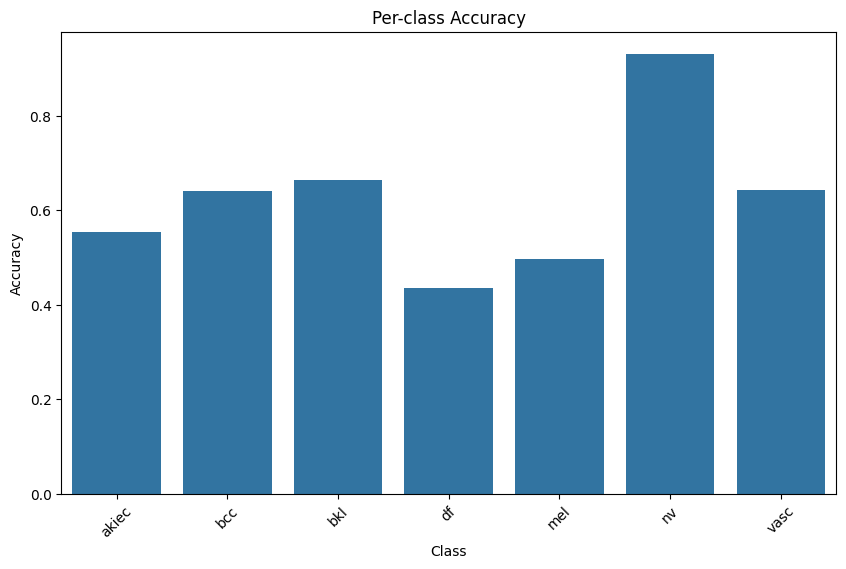

In [116]:
# Per-class Accuracy Plot
class_accuracies = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=class_accuracies)
plt.title('Per-class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

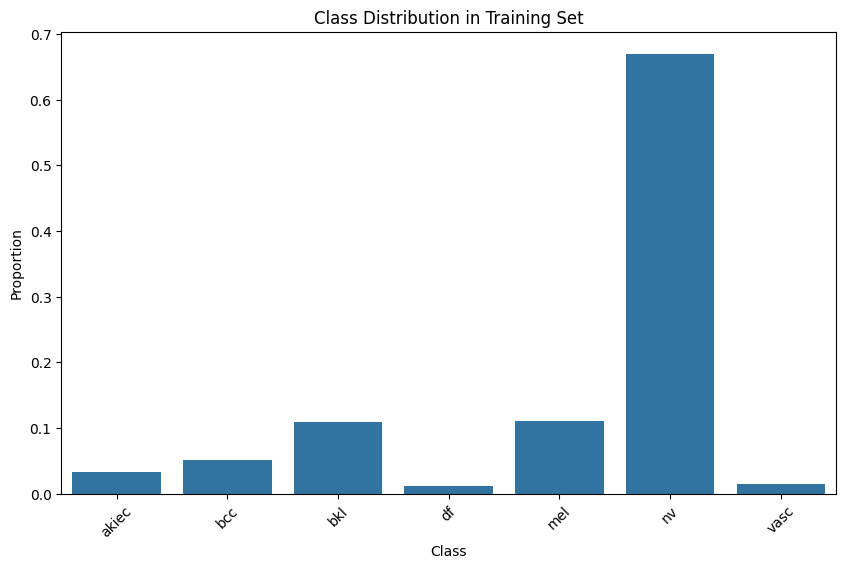

In [117]:
# Class distribution in training set
train_labels = np.concatenate([labels.numpy() for _, labels in train_dataset])
train_class_dist = np.bincount(train_labels) / len(train_labels)

plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=train_class_dist)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.show()